# Challenge Overview
Amyotrophic Lateral Sclerosis (ALS) is a devastating neurological disease that affects 1 in 400 people. Patients suffer a progressive loss of voluntary muscle control leading to paralysis, difficulty speaking, swallowing and ultimately, breathing. Over 60% of patients with ALS die within 3 years of clinical presentation and 90% will die within 10 years. But there is reason for hope.

We stand at a very important time and place in our mission to end ALS. Biotechnologies are rapidly evolving to produce new sources of data and change the way we learn about the brain in health and disease. Answer ALS has generated an unprecedented amount of clinical and biological data from ALS patients and healthy controls. We need your help to analyze that data, increase our understanding of ALS and bring clarity to potential therapeutic targets.

[Answer ALS](https://www.answerals.org), [EverythingALS](https://www.everythingals.org) and [Roche Canada's Artificial Intelligence Centre of Excellence] (https://betakit.com/roche-launching-national-ai-digital-health-initiative-alongside-amii-mila-vector-institute/) is requesting the collaborative effort of the AI community to fight ALS. This challenge presents a curated collection of datasets from a number of Answer ALS sources and asks you to model solutions to [key questions](https://www.kaggle.com/alsgroup/end-als/discussion/221210) that were developed and evaluated by ALS neurologists, researchers, and patient communities. See [Task Detail Pages](https://www.kaggle.com/alsgroup/end-als/discussion/221210) for more detail.

# Summary of Tasks
 - **Task #1: Does ALS have one mechanism of action (one pathway) or is it caused by multiple independent or different mechanisms of action (multiple pathways)**? For example, what is the genetic difference between people with ALS with Bulbar onset (they start the symptoms in bulbar functions) versus Limb (they start the symptoms in the limbs)?
  - For this task you might be especially interested in the following 3 data sources: ctrl_vs_case.csv, median_low_vs_high.csv, and bulbar_vs_limb.csv.  The L3_counts data is also likely to be useful.
 - **Task #2: What are potential mechanisms of disease progression?** Are there other population sub-classifications associated to ALS progression not traditionally considered within the clinical environment within the datasets? For reference: It is estimated that 60 percent of individuals with familial ALS have an identified genetic mutation. The cause of the condition in the remaining individuals is unknown. The C9orf72, SOD1, TARDBP, and FUS genes are key to the normal functioning of motor neurons and other cells.
  - For this task you might be especially interested in the following 3 data sources: ctrl_vs_case.csv, median_low_vs_high.csv, and bulbar_vs_limb.csv.  The L3_counts data is also likely to be useful.
 - **Task #3: What is the difference (genetic expression, transcriptomic, symptomatology) between people with ALS who progress faster versus those who develop it more slowly**? For example, what is the relationship between genetic expression and the scale ALSFRS subcategory scores?
   - For this task you might be especially interested in the following 3 data sources: ALSFRS_R.csv, /L3_counts/, and /genomics-data/.



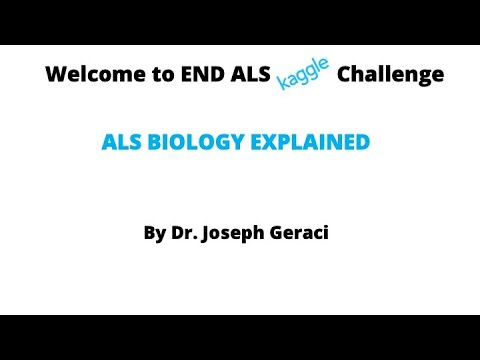

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('AdjRZnvnHF0', width=800, height=450)

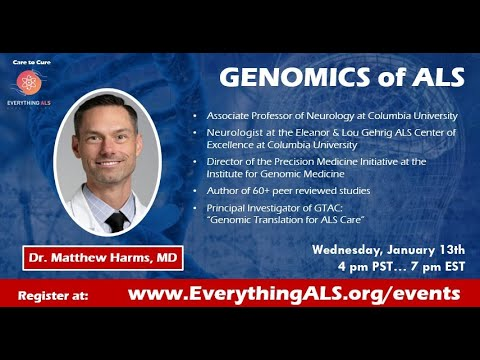

In [2]:
YouTubeVideo('v-4XB2ca4uQ', width=800, height=450)

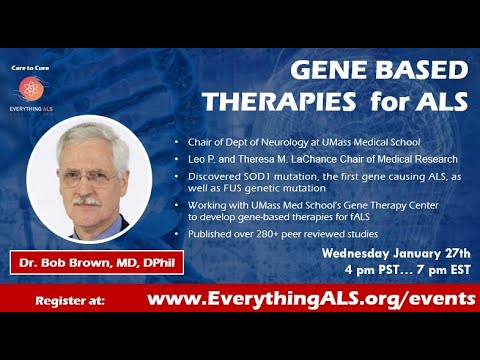

In [3]:
YouTubeVideo('dUb46Q3xZro', width=800, height=450)

***Step 1: Import Python packages***

In [4]:
!pip install scikit-allel

     |████████████████████████████████| 10.8 MB 4.4 MB/s 
  Created wheel for scikit-allel: filename=scikit_allel-1.3.3-cp37-cp37m-linux_x86_64.whl size=4760053 sha256=57a792120f02036fd6e9b10ca4fe5bfad338af4fa887c60ea37046165410012d
  Stored in directory: /root/.cache/pip/wheels/d3/0c/4c/cb7484ab7d56b84f83735852997236f6a8affc2021ffb1b68b
Successfully built scikit-allel


In [5]:
import numpy as np # data analysis
import pandas as pd # data analysis
import matplotlib.pyplot as plt # data vizualization
import seaborn as sns # data visualization
from sklearn.model_selection import train_test_split # machine learning
from sklearn.ensemble import RandomForestClassifier # machine learning
import shap # model explainability
import eli5 # model explainability
import allel # work with genetic data

***Step 2: Define helper functions***

In [6]:
def plot_feature_importances(df):
    '''
    Adapted from https://github.com/WillKoehrsen/feature-selector
    '''
    #Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    #Normalise the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    #Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10,6))
    ax = plt.subplot()
    #Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align = 'center', edgecolor = 'k')
    #Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    #Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importance')
    plt.show()
    return df

***Step 3: Load the data***

In [7]:
example_clinical_data_path_1 = '/kaggle/input/end-als/end-als/clinical-data/filtered-metadata/metadata/clinical/Demographics.csv'
example_clinical_data_path_2 = '/kaggle/input/end-als/end-als/clinical-data/filtered-metadata/metadata/clinical/ALSFRS_R.csv'
example_transcriptomics_DESEQ2_data_path_1 = '/kaggle/input/end-als/end-als/transcriptomics-data/DESeq2/bulbar_vs_limb.csv'
example_transcriptomics_DESEQ2_data_path_2 = '/kaggle/input/end-als/end-als/transcriptomics-data/DESeq2/ctrl_vs_case.csv'
example_transcriptomics_3counts_data_path = '/kaggle/input/end-als/end-als/transcriptomics-data/L3_counts/CASE-NEUZX521TKK/CASE-NEUZX521TKK-5793-T/CASE-NEUZX521TKK-5793-T_P85.exon.txt'

demographics = pd.read_csv(example_clinical_data_path_1)
demographics.to_csv('/kaggle/working/demographics.csv')
alsfrs_scores = pd.read_csv(example_clinical_data_path_2)
alsfrs_scores.to_csv('/kaggle/working/alsfrs_scores.csv')
bulbar_vs_limb = pd.read_csv(example_transcriptomics_DESEQ2_data_path_1)
bulbar_vs_limb.to_csv('/kaggle/working/bulbar_vs_limb.csv')
ctrl_vs_case = pd.read_csv(example_transcriptomics_DESEQ2_data_path_2)
ctrl_vs_case.to_csv('/kaggle/working/ctrl_vs_case.csv')
example_transcriptomics_3counts_data = pd.read_csv(example_transcriptomics_3counts_data_path,delim_whitespace=True,skiprows=1,low_memory=False)
example_transcriptomics_3counts_data.to_csv('/kaggle/working/L3_counts.csv')

There are 4 core data sources for this challenge: /transcriptomics-data/DESeq2/, /transcriptomics/L3_counts/, /clinical-data/, and /genomics-data/.  The field "Participant ID" can be used to join all of these data sources.

There are [2 core datasets](https://www.kaggle.com/alsgroup/end-als) containing transcriptomics data and transcript counts for ~100 ALS patients. These 2 core datasets are grouped into 2 separate folder: DESeq2 and L3_counts.  

The DESeq2 folder has the following 3 files: ctrl_vs_case.csv, median_low_vs_high.csv, and bulbar_vs_limb.csv. The first column is the Patient Name eg. NEUDE902GCT.  The second column is the classifier in numeric form Ctrl = 0, Case = 1; Bulbar = 0, Limb = 1; Mean of ALSFRS, where below Mean =0, above or equal to the Mean = 1; Median of ALSFRS, where below Median =0, above or equal to the Median = 1, etc.  

L3_counts folder: Level 3 data in transcriptomic summarize the counting results by featureCounts software. For each sample, the output is a tab delimited text file that includes annotation columns (‘Geneid’, ‘Chr’, ‘Start’, ‘End’, ‘Strand’ and ‘Length’) and a data column (i.e, read counts for genes). The annotation columns provide information about the counted feature such as ensembl gene ID, genomic location in terms of chromosome number and Start/End coordinates as well as strand and counting length. Only the data column for read count is usually used in differential analysis.

Another core data source for this challenge is the clinical metadata that can be found at /kaggle/input/end-als/clinical-data/filtered-metadata/meta-data/clinical/aals_dataportal_datatable.csv. In addition to the common clinical features such as sex and age at disease onset, we also include in the dataset stem cell differentiation related technical features such as protein staining data for 6 markers (NEFH, NKX6.1, s100b, TUBB3, Nestin and ISL1). These staining data range between 0 and 100 and represent the % of cells in the sample that express the specific marker, thus the proportion of certain cell types. Since cell type composition affects global gene expression profile, it may be helpful to include the staining data in the modeling. For example, staining data for s100b can be included as a covariate in the DESeq analysis. For more information about sample staining, see /kaggle/input/end-als/clinical-data/filtered-metadata/meta-data/clinical/Answer ALS metadata datatable with QC Staining.csv

The genomics data is provided in full in VCF format but also there is a processed .CSV file that is easier to work with that you can find at /genomics-data/geno_bin.csv.  In this starter notebook, we prepare a VCF ([variant call format](https://en.wikipedia.org/wiki/Variant_Call_Format)) file to apply ML models. These files contain information about the changes in the genome (e.g. A>C, T>G, etc.). The whole human genome has about 3 billion positions, but we usually have between 4 and 7 million variants, as more than 99% of our genomes are the same.  The **VCF** file has a long header (all lines starting with ##) with information about the chromosomes present in the file, the programs/parameters used to generate the file and the meaning of some fields we see in the file. After the long header, we have the column labels, which is a single line starting with #. This line has the following columns:
1. CHROM: variant chromosome
2. POS: variant position in the chromosome
3. ID: variant ID (usually rsID, from [dbSNP](https://www.ncbi.nlm.nih.gov/snp/))
4. REF: reference allele (A, T, C, G, ...)
5. ALT: alternate allele (A, T, C, G, ...)
6. QUAL: variant quality
7. FILTER: variant quality filter (usually generated by the [GATK VQSR](https://gatk.broadinstitute.org/hc/en-us/articles/360035531612-Variant-Quality-Score-Recalibration-VQSR-) tool)
8. INFO: variant annotation (information like the gene name, variant location in the gene, functional impact, frequency in the population, etc.)
9. FORMAT: order of additional fields about the genotypes
10. ... From column 10 on, we have the information about the samples. The main information we want is how many copies each sample has of the reference (always represented by 0) and alternate alleles (represented by 1, 2, 3, ...). Let's say a specific variant is a change from A to G. Then A is the reference allele and G is the alternate allele. If a patient has two copies of the reference allele, we will see the genotype as "0/0". If the patient has one copy of the reference and one copy of the alternate allele, we will see the genotype as "0/1", and if the patient has two copies of the alternate allele, we will see "1/1". In some cases, more than one alternate alleles will be found (let's say most individuals have a T, but some can have a C and some can have a G). In these cases, we will see other combinations like "0/2" (the patient has one copy of the reference and one copy of the second most frequent alternate allele).

To simplify the analysis, we coded the variants as binary data, meaning that patients with at least one copy of the alternate allele will have 1 for that variant and if the patient has only the reference allele, the value will be 0.

To filter the variants for this competition, we selected variants that passed the GATK VQSR quality control, removed variants that are outside genes (intergenic regions of the genome), and selected only variants with a frequency of 10% or less.



All four core datasets have all been collected and deposited into a central location [here](https://www.kaggle.com/alsgroup/end-als/data).  For additional detail about these datasets, you can refer to https://www.kaggle.com/alsgroup/end-als/discussion/218964.

***Step 4: Preview the data***

Demographics and ALSFRS Scores

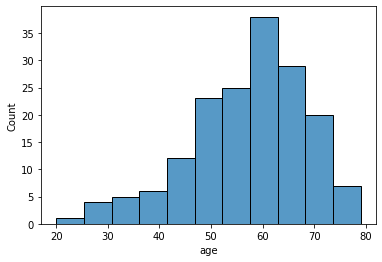

In [8]:
sns.histplot(demographics.age);

In [9]:
print('Demographics:\n\n')
demographics.head(5)

Demographics:




,Participant_ID,SubjectUID,Form_Name,Visit_Name,Visit_Date,age,dob,ethnic,raceamin,raceasn,raceblk,racenh,racewt,sex
0,CASE-NEUAA599TMX,NEUAA599TMX,Demographics,Baseline,0,78,-28685,2,0,0,0,0,1,2
1,CASE-NEUAB000NKC,NEUAB000NKC,Demographics,Baseline,0,52,-19255,2,0,0,0,0,1,2
2,CASE-NEUAE993EPR,NEUAE993EPR,Demographics,Baseline,-1,60,-21948,2,0,0,1,0,0,2
3,CASE-NEUAF553MJ3,NEUAF553MJ3,Demographics,Baseline,0,70,-25857,2,0,0,0,0,1,2
4,CASE-NEUAG603XLK,NEUAG603XLK,Demographics,Baseline,0,55,-20281,2,0,0,0,0,1,2


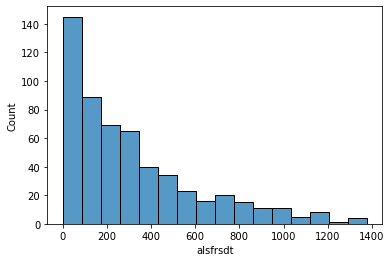

In [10]:
sns.histplot(alsfrs_scores.alsfrsdt);

In [11]:
print('ALSFRS Scores:\n\n')
alsfrs_scores.head(5)

ALSFRS Scores:




,Participant_ID,SubjectUID,Form_Name,Visit_Name,Visit_Date,alsfdn,alsfdnsp,alsfrs1,alsfrs2,alsfrs3,...,alsfrsdt,alsfrsmd,alsfrsr1,alsfrsr2,alsfrsr3,alsfrsrp,alsfrssp,alsfrst,source,sourcesp
0,CASE-NEUAA599TMX,NEUAA599TMX,ALSFRS-R,ANSWER-ALS Visit 2,154,1,NaN,1.0,3.0,2.0,...,154.0,1.0,1.0,4.0,2.0,1.0,NaN,26.0,2.0,NaN
1,CASE-NEUAA599TMX,NEUAA599TMX,ALSFRS-R,ANSWER-ALS Screening Visit,0,1,NaN,2.0,4.0,2.0,...,0.0,1.0,2.0,4.0,4.0,1.0,NaN,33.0,2.0,NaN
2,CASE-NEUAB000NKC,NEUAB000NKC,ALSFRS-R,ANSWER-ALS Visit 2,114,1,NaN,4.0,4.0,4.0,...,114.0,2.0,4.0,4.0,4.0,1.0,NaN,38.0,2.0,NaN
3,CASE-NEUAB000NKC,NEUAB000NKC,ALSFRS-R,ANSWER-ALS Screening Visit,0,1,NaN,4.0,4.0,4.0,...,0.0,1.0,4.0,4.0,4.0,1.0,NaN,40.0,2.0,NaN
4,CASE-NEUAB000NKC,NEUAB000NKC,ALSFRS-R,ANSWER-ALS Visit 3,157,1,NaN,4.0,4.0,4.0,...,157.0,1.0,4.0,4.0,4.0,1.0,NaN,37.0,2.0,NaN


Case vs Ctrl and Bulbar vs Limb

In [12]:
print('bulbar_vs_limb:\n')
bulbar_vs_limb.head(5)

bulbar_vs_limb:



,Participant_ID,SiteOnset_Class,DDX11L1,WASH7P,MIR6859.1,MIR1302.2HG,FAM138A,OR4G11P,OR4F5,AL627309.1,...,AC023491.1,AC004556.3,ENSG00000278246,AC240274.1,ENSG00000278033,U1.4,U1.5,AC213203.2,AC213203.1,ENSG00000278858
0,NEUAB000NKC,1,0.000000,188.401759,32.563267,1.162974,0.000000,0.000000,0.0,5.814869,...,0.000000,2.325948,0.000000,384.944335,0.000000,94.200880,2.325948,5.814869,0.0,0
1,NEUAF553MJ3,0,0.000000,199.081434,41.519657,3.193820,0.000000,0.000000,0.0,15.969099,...,1.064607,6.387640,0.000000,820.811688,0.000000,57.488756,3.193820,1.064607,0.0,0
2,NEUAG603XLK,1,2.152546,122.695105,34.440731,2.152546,0.000000,2.152546,0.0,8.610183,...,0.000000,2.152546,0.000000,585.492430,0.000000,60.271280,0.000000,4.305091,0.0,0
3,NEUAM655HF7,1,0.000000,91.017494,19.679458,1.229966,0.000000,0.000000,0.0,4.919865,...,0.000000,2.459932,1.229966,439.097910,0.000000,56.578442,1.229966,0.000000,0.0,0
4,NEUAT234RK6,1,0.901067,154.983586,36.943762,7.208539,0.901067,0.000000,0.0,11.713876,...,0.000000,5.406404,0.000000,554.156427,1.802135,90.106736,0.000000,1.802135,0.0,0


In [13]:
print('ctrl_vs_case:\n')
ctrl_vs_case.head(5)

ctrl_vs_case:



,Participant_ID,CtrlVsCase_Classifier,DDX11L1,WASH7P,MIR6859.1,MIR1302.2HG,FAM138A,OR4G11P,OR4F5,AL627309.1,...,AC023491.1,AC004556.3,ENSG00000278246,AC240274.1,ENSG00000278033,U1.4,U1.5,AC213203.2,AC213203.1,ENSG00000278858
0,NEUAB000NKC,1,0.000000,188.401759,32.563267,1.162974,0.0,0.000000,0.0,5.814869,...,0.000000,2.325948,0.000000,384.944335,0.0,94.200880,2.325948,5.814869,0.0,0.0
1,NEUAE993EPR,1,0.000000,233.423189,27.412688,1.661375,0.0,0.000000,0.0,4.984125,...,0.000000,4.153438,0.000000,462.692940,0.0,34.888875,0.000000,0.830688,0.0,0.0
2,NEUAF553MJ3,1,0.000000,199.081434,41.519657,3.193820,0.0,0.000000,0.0,15.969099,...,1.064607,6.387640,0.000000,820.811688,0.0,57.488756,3.193820,1.064607,0.0,0.0
3,NEUAG603XLK,1,2.152546,122.695105,34.440731,2.152546,0.0,2.152546,0.0,8.610183,...,0.000000,2.152546,0.000000,585.492430,0.0,60.271280,0.000000,4.305091,0.0,0.0
4,NEUAM655HF7,1,0.000000,91.017494,19.679458,1.229966,0.0,0.000000,0.0,4.919865,...,0.000000,2.459932,1.229966,439.097910,0.0,56.578442,1.229966,0.000000,0.0,0.0


L3_counts data

In [14]:
print('example_transcriptomics_3counts_data:\n')
example_transcriptomics_3counts_data.head(5)

example_transcriptomics_3counts_data:



,Geneid,Chr,Start,End,Strand,Length,/share/crsp/lab/lmthomps/jiew5/121319_aals102/alignments_quantification/hisat2_121319/hisat_nR022-L2-P085-GATTGTCC-TCGGATTC_121319/nR022-L2-P085-GATTGTCC-TCGGATTC.sorted.bam
0,ENSG00000223972,1;1;1;1,11869;12613;12975;13221,12227;12721;13052;14409,+;+;+;+,1735,0
1,ENSG00000227232,1;1;1;1;1;1;1;1;1;1;1,14404;15005;15796;16607;16858;17233;17606;1791...,14501;15038;15947;16765;17055;17368;17742;1806...,-;-;-;-;-;-;-;-;-;-;-,1351,144
2,ENSG00000278267,1,17369,17436,-,68,29
3,ENSG00000243485,1;1;1,29554;30267;30976,30039;30667;31109,+;+;+,1021,3
4,ENSG00000274890,1,30366,30503,+,138,0


Genomics Data

* Quick preview of the genomics data:

In [15]:
print('example_genomics_data:\n')
example_vcf_file = "/kaggle/input/end-als/end-als/genomics-data/AnswerALS_subset_annovar.hg38_anno_and_geno.no_intergenic.vcf"
df = allel.vcf_to_dataframe(example_vcf_file)
df.to_csv('/kaggle/working/vcf_converted_to_csv.csv')
df.head(20)

example_genomics_data:



,CHROM,POS,ID,REF,ALT_1,ALT_2,ALT_3,QUAL,FILTER_PASS
0,chr1,16378,.,T,C,NaN,NaN,53076.988281,False
1,chr1,16487,.,T,C,NaN,NaN,15370.209961,False
2,chr1,16495,.,G,C,NaN,NaN,63161.878906,False
3,chr1,16534,.,C,T,NaN,NaN,19334.199219,False
4,chr1,16567,.,G,C,NaN,NaN,270.350006,False
5,chr1,16571,.,G,A,NaN,NaN,3495.120117,False
6,chr1,16576,.,A,C,NaN,NaN,52.180000,False
7,chr1,16631,.,T,C,NaN,NaN,132.139999,False
8,chr1,16682,.,G,A,NaN,NaN,1147.170044,False
9,chr1,16688,.,G,A,NaN,NaN,1188.619995,False


* Reformat the genomics data and add ParticipantID to make the data easier to work with (thanks to @lelimat for providing the following code snippets!):

In [16]:
data_dir = '/kaggle/input/end-als/end-als/genomics-data'
filename = data_dir + '/AnswerALS_subset_annovar.hg38_anno_and_geno.no_intergenic.vcf'
chunksize = 2 * 10 ** 4
nrows = 10945503
chunks = pd.read_csv(filename, sep = '\t', skiprows=3518, chunksize=chunksize)
df = pd.DataFrame()

def get_rsID(INFO):
    return [x.split('=')[1] for x in INFO.split(';') if x.startswith('avsnp150')][0]

def get_maxMAF(INFO):
    freq_columns = ['ExAC_nontcga_ALL', 'esp6500siv2_all']
    freqs = []
    for info in INFO.split(';'):
        if info.startswith('ExAC_nontcga_ALL') or info.startswith('esp6500siv2_all'):
            freq = info.split('=')[1]
            freqs.append(float('0'+freq))
    return max(freqs)

def is_exonic(INFO):
    functions = [x.split('=')[1] for x in INFO.split(';') if x.startswith('Func.ensGene') or x.startswith('Func.refGene') or x.startswith('Func.knownGene')]
    return 'exonic' in functions

for i,chunk in enumerate(chunks):
    if i % 100 == 0:
        print(f"{i+1} out of {int(nrows/chunksize)} chunks.")
    # Selecting PASSing variants (according to GATK VQSR)
    data = chunk[chunk.FILTER == 'PASS']
    # Selecting exonic variants only
    data = data[data.INFO.apply(is_exonic)]
    # Selecting variants with frequency 10% or less
    data = data[data.INFO.apply(lambda x: get_maxMAF(x) <= 0.1)]
    # Defining index with SNP ID
    data.index = data[['#CHROM', 'POS', 'INFO']].apply(lambda x: get_rsID(x[2]) if get_rsID(x[2]) != '.' else x[0]+':'+str(x[1]), axis=1)
    # Selecting genotype columns only
    geno = data.iloc[:,9:]
    # Replacing genotype codes with 0s and 1s
    for col in geno.columns:
        geno[col] = geno[col].apply(lambda x: 0 if x.split(':')[0] == '0/0' else (np.nan if x.split(':')[0] == './.' else 1))       
    #print(geno.shape)
    #geno.to_csv(f'{data_dir}/geno{i+1}.csv')  
    # Concatenating to the dataframe
    df = pd.concat([df, geno])
    
meta_dir = '/kaggle/input/end-als/end-als/clinical-data/filtered-metadata/metadata/'
metadata = pd.read_csv(meta_dir + 'aals_released_files.csv')
metadata = metadata[['Participant_ID', 'CGND_ID']].drop_duplicates()
metadata = metadata[-metadata.CGND_ID.isnull()]
metadata = metadata[-metadata.Participant_ID.isnull()]

for i,row in metadata.iterrows():
    if row['CGND_ID'] in df.columns:
        df = df.rename(columns = {row['CGND_ID'] : row['Participant_ID']})
    if row['CGND_ID']+'-b38' in df.columns:
        df = df.rename(columns = {row['CGND_ID']+'-b38' : row['Participant_ID']})
df.to_csv('/kaggle/working/geno.csv')
# This file is already provided for you in the following location:
# '/kaggle/input/end-als/end-als/genomics-data/geno_bin.csv'

1 out of 547 chunks.
101 out of 547 chunks.
201 out of 547 chunks.
301 out of 547 chunks.
401 out of 547 chunks.
501 out of 547 chunks.


In [17]:
geno_bin = pd.read_csv('/kaggle/input/end-als/end-als/genomics-data/geno_bin.csv')
geno_bin.to_csv('/kaggle/working/geno_bin.csv')
geno_bin.head(25)

,Unnamed: 0,CASE-NEUMN012EVP,CASE-NEUJY426MBU,CASE-NEUTM934BPY,CASE-NEUGD965XVD,CASE-NEUJA217MTJ,CASE-NEUTA057AF6,CASE-NEUZV656DD1,CASE-NEUJH197AK2,CASE-NEUZN836GME,...,CTRL-NEUHZ716BZ2,CTRL-NEUZL045YD3,CTRL-NEULL933JXY,CASE-NEUEB422WW0,CASE-NEUGE540TC4,CTRL-NEUFL840LZE,CTRL-NEUDA782GW3,CTRL-NEUNW343RXP,CASE-NEUPD674JPG,CTRL-NEUCV809LL4
0,rs41285790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rs772007449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,rs9988179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,rs28419423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,rs200848321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,rs751035336,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,rs199625867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,rs145967298,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,rs568340123,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,rs745625383,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


***Step 5: Train a machine learning model***

 For this example we will walk through one potential approach for addressing Task #1:
 
 - Task #1: Does ALS have one mechanism of action (one pathway) or is it caused by multiple independent or different mechanisms of action (multiple pathways)? For example, what is the genetic difference between people with ALS with Bulbar onset (they start the symptoms in bulbar functions) versus Limb (they start the symptoms in the limbs)?
 
Specifically, we will: (1) train a machine learning model to predict "bulbar vs limb"; (2) investigate why your machine learning model made the predictions that it did; (3) identify what genes or transcripts counts might be most predictive for developing bulbar ALS vs limb ALS; and (4) provide a logical rationale for why these genes might be worthy of future laboratory research studies.  Does it make sense if you take the time to also investigate the role of these same genes in known biological pathways?

In [18]:
training_data = bulbar_vs_limb.drop(['SiteOnset_Class','Participant_ID'],axis=1)
labels = bulbar_vs_limb['SiteOnset_Class']
X_train, X_test, y_train, y_test = train_test_split(training_data, labels, train_size=0.9, random_state=0)

In [19]:
features = list(X_train.columns)
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

For this example, we are training a machine learning model and then we are interpreting the results, within the context of predicting bulbar vs limb for ALS patients.  We are not taking the time to assess the accuracy and the performance of our model. This was done for the sake of brevity -- in your own submission you should definitely assess the accuracy and the performance of your model. For example, this dataset has a large amount of data about a small number of patients and therefore you will have to take extra special care not to overfit to the training data.

***Step 6: Explain why your machine learning model made the predictions that it did***

One option for explaining your models predictions is to investigate the feature importance values and the shap values.  The eli5 and shap Python packages are great for this.  It can be a challenging task if you are starting from scratch.  Best of luck!

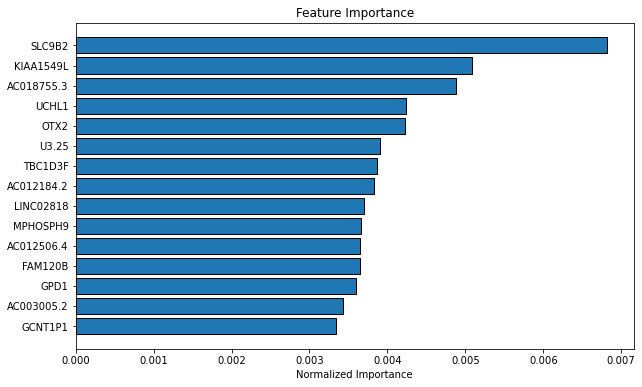

In [20]:
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance':feature_importance_values})
feature_importances_sorted = plot_feature_importances(feature_importances)

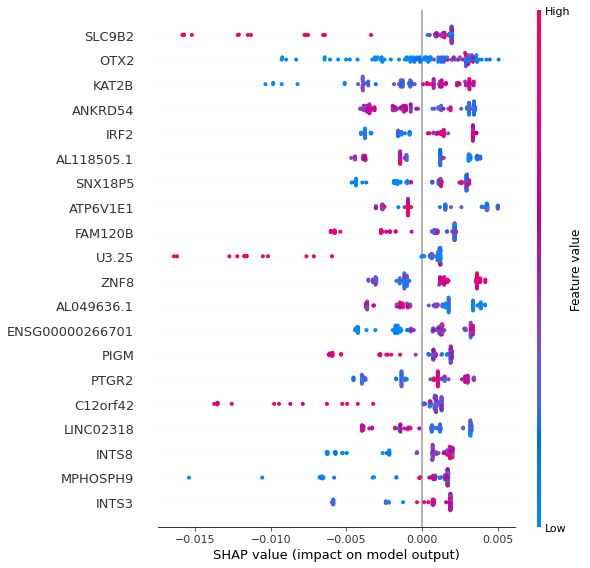

In [21]:
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train)

***Step 7: Identify genes that might be of interest to ALS researchers and explain your rationale***

For example, you can find a gene that has a very high feature importance value for your model that was used to predict bulbar vs limb for ALS patients.  And then you can research about this gene, and try to see if maybe it fits into a relevant biological pathway.  Are the genes that your machine learning model identified good targets for future laboratory researchers to investigate in more detail?  Why do you think so?  Use markdown cells and a text narrative to thoroughly explain your rationale.

{0: 'Bulbar', 1: 'Limb'}


Text(0.5, 0.98, 'SLC9B2 counts vs Diagnosis (0 = Bulbar; 1 = Limb)')

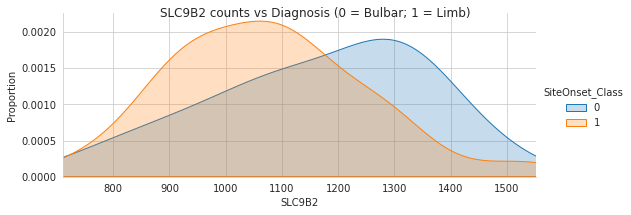

In [22]:
dict_characters = {0: 'Bulbar', 1: 'Limb'} # double check this
print(dict_characters)
sns.set_style("whitegrid")
plt = sns.FacetGrid(bulbar_vs_limb, hue='SiteOnset_Class',aspect=2.5)
plt.map(sns.kdeplot,'SLC9B2',shade=True)
plt.set(xlim=(bulbar_vs_limb['SLC9B2'].min(), bulbar_vs_limb['SLC9B2'].max()))
plt.add_legend()
plt.set_axis_labels('SLC9B2', 'Proportion')
plt.fig.suptitle('SLC9B2 counts vs Diagnosis (0 = Bulbar; 1 = Limb)')

I identified the gene SLC9B2 as potentially being important for predicting if a patient develops bulbar ALS vs limb ALS.  But [when I go to research about that same gene](https://www.ncbi.nlm.nih.gov/gene?Db=gene&Cmd=DetailsSearch&Term=133308), I am not finding much that would help us to validate or increase our confidence level in that particular result.  I'll need to do a bit more research about this gene -- learn about the biological pathways that it might be relevant to -- and also I should research some of the other top candidates that we identified.  Maybe something will come up when I research about it on [genemania.org](http://apps.cytoscape.org/apps/genemania)?

[The genemania tool](http://apps.cytoscape.org/apps/genemania) allows you to explore the ways different proteins interact with each other. Some of the things you will find will not be found within GeneMania because it is part of our genetics that doesn't code for a protein, or it is poorly understood. But other variables you find will be searchable. You can take collections of these genes and use GeneMania to see if they are part of a biological pathway that does indeed make sense! For those of you who are experienced at this sort of thing, I would like to recommend that you download an amazing professional level tool called [Navigator](http://navigator.ophid.utoronto.ca/navigatorwp/). These tools are what biologists and their computer science colleagues use to make sense of our molecular machinery. We encourage you to create a story from these tools if you are so inclined. Remember the task here: we want you to use your abilities to help us untangle which variables are driving different aspects of ALS. Good luck! Thanks to the [Bader](https://baderlab.org/) and [Jurisica](https://www.cs.toronto.edu/~juris/home.html) labs. 

For more detail, watch the video below:

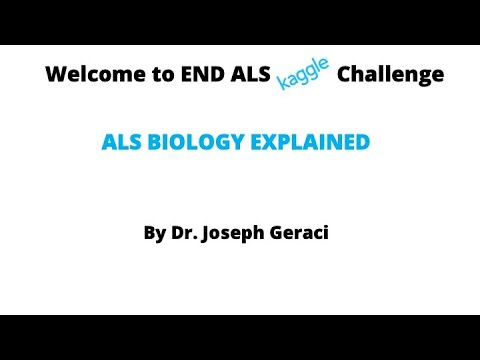

In [23]:
YouTubeVideo('AdjRZnvnHF0', width=800, height=450)

In [24]:
import time
from datetime import datetime
import sklearn
import matplotlib

print(f'Notebook last run on {datetime.fromtimestamp(time.time()).strftime("%Y-%m-%d, %H:%M:%S UTC")}\n')
print('- numpy version ',np.__version__)
print('- pandas version ',pd.__version__)
print('- matplotlib version ',matplotlib.__version__)
print('- seaborn version ',sns.__version__)
print('- scikit-learn version ',sklearn.__version__)
print('- shap version ',shap.__version__)
print('- eli5 version ',eli5.__version__)
print('- allel version ',allel.__version__)

!mkdir /kaggle/working/docker/
!pip freeze > '../working/docker/requirements.txt'

Notebook last run on 2021-03-17, 22:20:38 UTC

- numpy version  1.19.5
- pandas version  1.2.0
- matplotlib version  3.3.3
- seaborn version  0.11.1
- scikit-learn version  0.23.2
- shap version  0.38.1
- eli5 version  0.11.0
- allel version  1.3.3
